In [1]:
import os
from matplotlib import image
from matplotlib import pyplot as plt
import cv2
import pandas as pd
import random
import torch
from torch import nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision.utils as vutils
import numpy as np
import matplotlib.animation as animation
from IPython.display import display
from ipywidgets import IntProgress
import datetime
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device) # A single 1070 Ti

cuda:0


In [2]:
# We will be generating cats. Dataset is "10k cats", available here: https://www.kaggle.com/datasets/crawford/cat-dataset (that download includes two copies, we only need one)
# get the paths to all our images so we don't have to unpack the folder structure or worry about files we don't care about
pathlist = []
for root, subdirs, files in os.walk(r"C:\Users\migue\Documents\Uni\AI\data\cats"):
    for file in files:
        if file[-4:] == '.jpg':
            pathlist.append(os.path.join(root, file))

Image number 3197


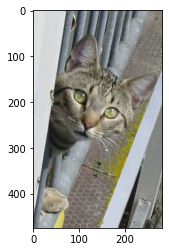

In [9]:
def show_image(path): 
    im = image.imread(path)
    plt.imshow(im)
n = np.random.randint(0, len(pathlist))
show_image(pathlist[n])
print('Image number', n)

In [3]:
def preprocess(path=False):
    if not path:
        path = pathlist[np.random.randint(0,len(pathlist)-1)]
    img = image.imread(path)
    img = cv2.resize(img, (64,64)) # This will stretch images instead of cropping so that we don't cut off parts of cats
    # Note: When increasing the resolution, we will need to increase the strides of our conv layers or add more layers
    img = np.transpose(img, (2,0,1)) # go from shape (64,64,3) to (3,64,64)
    img_tensor = torch.from_numpy(img).type('torch.FloatTensor')
    img_tensor *= (1/255) # scale to [0,1]
    img_tensor = img_tensor.unsqueeze(0) # Put it into batch format so we can feed it directly into the discriminator
    return img_tensor.to(device)
# preprocess() # Test to see if works

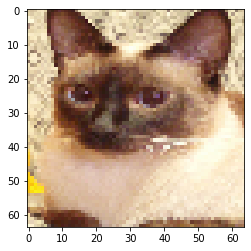

In [4]:
# Let's look at what the model gets as input
img = image.imread(pathlist[58])
img = cv2.resize(img, (64,64))
plt.imshow(img)
# print(img)

In [6]:
def stack(imgs=False, n=5):
    if not imgs:
        imgs = []
        for i in range(n):
            imgs.append(preprocess().squeeze())
    return torch.stack(tuple(imgs))
# stack() # Test to see if it works

In [8]:
# Network for telling real images apart from generated ones

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main=nn.Sequential(
            # State size: 3x64x64 (3 colors, 64x64 pixels)
            nn.Conv2d(3, 64, 4, 2, 1, bias=False), 
            nn.LeakyReLU(0.2, inplace=True),
            # State size: 64x32x32 (stride of 2 halves each dimension of the input)
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: 128x16x16
            nn.Conv2d(128, 256, 4, 2, 1), 
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # State Size: 256x8x8
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # State size 512x4x4
            nn.Conv2d(512, 1, 4, 1, 0, bias=False), # single output neuron
            nn.Sigmoid()
            # State size 1x1x1
        )
    def forward(self, input):
        return self.main(input)

In [9]:
# Network for generating new images

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # State size 100x1x1
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False), # Reverse convolution
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            # state size 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # state size 256 x 8 x 8
            nn.ConvTranspose2d( 256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # state size 128 x 16 x 16
            nn.ConvTranspose2d( 128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # state size 64 x 32 x 32
            nn.ConvTranspose2d( 64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. 3 x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [10]:
def weights_init(m): # Initialize the weights of neural network with a gaussian distribution
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02) # 0 mean, 0.02 standard deviation
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [11]:
# Instantiate networks and send them off to the GPU

dis = Discriminator().to(device)
dis.apply(weights_init)
gen = Generator().to(device)
dis.apply(weights_init)

# print(dis, '\n\n', gen)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [12]:
# set up optimizers for training
gen_optimizer = optim.Adam(gen.parameters(), lr= 0.005, betas=(0.5, 0.999))
dis_optimizer = optim.Adam(dis.parameters(), lr= 0.00002, betas=(0.5, 0.999)) # Much lower learning rate so that it doesn't outlearn the generator

In [13]:
# The important part: Now we train both nets

criterionBCE = nn.BCELoss()

runtime_history = [] # So we can optimize the loop further once it produces good results. My 1070 Ti runs at only 70W when training, so there's some headroom

def train(n_epochs, batchsize=5):
    progress_bar = IntProgress(min=0, max=n_epochs)
    display(progress_bar)
    for epoch in range(n_epochs):
        runtime = []
        runtime.append(['Start of training loop', time.time_ns()])
        progress_bar.value += 1
        
        dis.zero_grad()
        output_dis_real = dis(stack(n=batchsize)).view(-1) # random real images
        err_dis_real = criterionBCE(output_dis_real, torch.full((batchsize,), 1, dtype=torch.float, device=device)) # Label is always 1 for real images
        dis_history.append(err_dis_real.detach().cpu())
        err_dis_real.backward(retain_graph=True)
        runtime.append(['After dis_real backpropagation', time.time_ns()])
        # print('Discriminator output on real image:',output_dis_real)

        # Train discriminator with fake images
        fake_img = gen(torch.randn(batchsize, 100, 1, 1, device=device)) # 100 is size of latent vector (where the seed noise comes in)
        output_dis_fake = dis(fake_img).view(-1)
        err_dis_fake = criterionBCE(output_dis_fake, torch.full((batchsize,), 0, dtype=torch.float, device=device)) # Label is always 0 for fake images
        err_dis_fake.backward(retain_graph=True) # makes err_gen.backward() dump if set to false. Online discussion doesn't recommend it but it seems to not be an issue.
        # print('Discriminator output on fake image:',output_dis_fake)
        dis_history.append(err_dis_fake.detach().cpu())
        runtime.append(['After dis_fake backpropagation', time.time_ns()])
        dis_optimizer.step()
        runtime.append(['After dis optimizer step', time.time_ns()])

        # Train generator
        gen.zero_grad()
        output_dis_fake = dis(fake_img).view(-1) # Refresh discriminator output after training
        # Intuition: A good generator will produce images that fool the discriminator, so its loss function is the opposite of the discriminator's
        err_gen = criterionBCE(output_dis_fake, torch.full((batchsize,), 1, dtype=torch.float, device=device)) # Important: label for fake image is now 1 instead of 0
        gen_history.append(err_gen.detach().cpu())
        err_gen.backward(retain_graph=True)
        runtime.append(['After gen backpropagation', time.time_ns()])
        gen_optimizer.step()
        runtime.append(['After gen optimizer step', time.time_ns()])
        
        # get some images from the same noise every time so we can check how the generator evolves
        monitoring_fake = gen(monitoring_input).detach().squeeze().cpu()
        monitoring_buffer.append(monitoring_fake)
        runtime.append(['After saving monitoring (end)', time.time_ns()])
        runtime_history.append(runtime.copy())


In [14]:
monitoring_input = torch.randn(1, 100, 1, 1, device=device) # random but fixed across a training session
monitoring_buffer = []
dis_history = []
gen_history = []

train(5000, 100) # 2 hours on a 1070 Ti

path_saved_dis = 'C:\\Users\\migue\\Documents\\Uni\\Neue_Konzepte\\models\\' + str(datetime.datetime.now().strftime("%Y-%m-%d---%H-%M-%S")) + '_dis.torch'
path_saved_gen = 'C:\\Users\\migue\\Documents\\Uni\\Neue_Konzepte\\models\\' + str(datetime.datetime.now().strftime("%Y-%m-%d---%H-%M-%S")) + '_gen.torch'

# torch.save(dis, path_saved_dis)
# torch.save(gen, path_saved_gen)

IntProgress(value=0, max=5000)

# Results
Lets see what went wrong so we can fix it

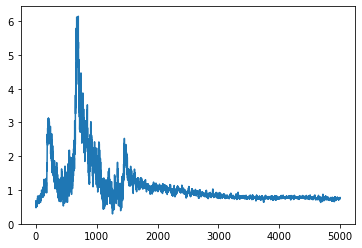

In [31]:
plt.plot(dis_history[::2]) # even numbers -> real images

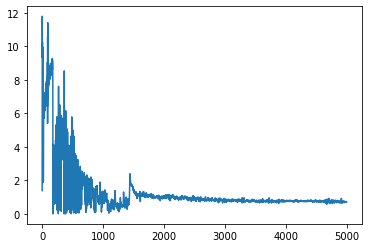

In [32]:
plt.plot(dis_history[1::2]) # uneven numbers -> fake images

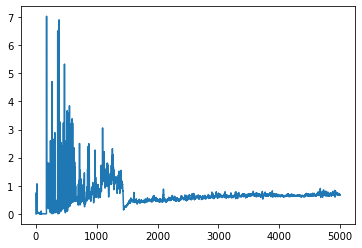

In [30]:
plt.plot(gen_history)
# Looks rather stable after 1500 epochs but the discriminator seems to be outlearning the generator.
# Maybe reduce the discriminator's LR further and train again?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


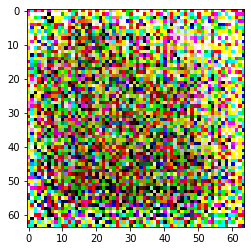

In [79]:
# After 500 epochs the generator just barely grasped the concept of images
plt.imshow(np.transpose(monitoring_buffer[600], (1,2,0)))

In [ ]:
# Get a random image from our final generator
# plt.imshow(np.transpose(gen(torch.randn(1, 100, 1, 1, device=device)).detach().squeeze().cpu(), (1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


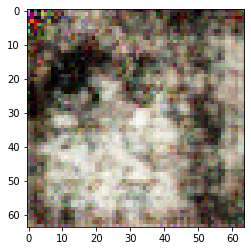

In [20]:
# Look at what the final generator makes of our fixed input
plt.imshow(np.transpose(monitoring_buffer[-1], (1,2,0)))
# That's definitely an eye. Let's call it a success instead of breaking it again.